In [1]:
import random
import torch
import numpy as np
from torch.utils import data
import matplotlib.pyplot as plt
import time

data_train = torch.from_numpy(np.loadtxt('two_spiral_train_data.txt')).float()
data_test = torch.from_numpy(np.loadtxt('two_spiral_test_data.txt')).float()

In [2]:
class SpiralNet:
    def __init__(self, hidden, batch, r, epoch):
        # 训练参数
        self.batch_size = batch
        self.input_num = 2
        self.hidden_num = hidden
        self.output_num = 2
        self.lr = r
        self.epoch_num = epoch
        # 参数
        self.u1 = torch.normal(0, 0.01, size = (self.input_num, self.hidden_num), requires_grad = True)
        self.v1 = torch.normal(0, 0.01, size = (self.input_num, self.hidden_num), requires_grad = True)
        self.b1 = torch.zeros(self.hidden_num, requires_grad=True)
        self.u2 = torch.normal(0, 0.01, size = (self.hidden_num, self.output_num), requires_grad = True)
        self.v2 = torch.normal(0, 0.01, size = (self.hidden_num, self.output_num), requires_grad = True)
        self.b2 = torch.zeros(self.output_num, requires_grad=True)
        
    def load_data(self, data_ori, is_train = True):
        data_in = data_ori[:, 0:2]
        data_out = data_ori[:, 2]
        return data.DataLoader(data.TensorDataset(data_in, data_out), self.batch_size, shuffle = is_train)
        
    def quadratic_layer(self, u, v, b, x):
        return torch.matmul(x**2, u) + torch.matmul(x, v) + b    
    
    def sigmoid(self, x):
        x_exp = torch.exp(-x)
        return 1 / (1 + x_exp)
    
    def softmax(self, x):
        x_max = torch.max(x)
        x_exp = torch.exp(x - x_max)
        partition = x_exp.sum(1, keepdim=True)
        return x_exp / partition
    
    def mlqp(self, x, u1, v1, b1, u2, v2, b2):
        out1 = self.sigmoid(self.quadratic_layer(u1, v1, b1, x))
        out2 = self.quadratic_layer(u2, v2, b2, out1)
        return self.softmax(out2)
    
    def square_error(self, y_hat, y):
        return (y_hat - y)**2
    
    def cross_entropy(self, y_hat, y):
        return -1 * torch.log(y_hat[range(len(y_hat)), y])

    def sgd(self):
        with torch.no_grad():
            for param in [self.u1, self.v1, self.b1, self.u2, self.v2, self.b2]:
                #print(param.grad)
                param -= self.lr * param.grad / self.batch_size
                param.grad.zero_()
                
    def accuracy(self, y_hat, y):
        y_hat = y_hat.argmax(axis=1)
        cmp = y_hat.type(y.dtype) == y
        return float(cmp.type(y.dtype).sum())

    def train_spiral(self, train_iter):
        accuracy_max = 0
        for i in range(self.epoch_num):
            accuracy_rate = [0., 0., 0.] # loss, predict right, num
            for x, y in train_iter:
                y_hat = self.mlqp(x, self.u1, self.v1, self.b1, self.u2, self.v2, self.b2)
                #print(y.long())
                l = self.cross_entropy(y_hat, y.long())
                #print(l)
                #updater.zero_grad()
                l.sum().backward()
                #updater.step()
                self.sgd()
                accuracy_rate[0] = accuracy_rate[0] + l.sum()
                accuracy_rate[1] = accuracy_rate[1] + self.accuracy(y_hat, y)
                accuracy_rate[2] = accuracy_rate[2] + y.numel()
            accuracy_now = accuracy_rate[1] / accuracy_rate[2]
            if accuracy_now > accuracy_max:
                accuracy_max = accuracy_now
                print('max accuracy:', accuracy_max)
                self.u1_max, self.v1_max, self.b1_max, self.u2_max, self.v2_max, self.b2_max = self.u1 * 1, self.v1 * 1, self.b1 * 1, self.u2 * 1, self.v2 * 1, self.b2 * 1
            print('loss: {0}, accuracy: {1}'.format(accuracy_rate[0] / accuracy_rate[2], accuracy_rate[1] / accuracy_rate[2]))
            
            
    def plot_decision_boundary(self, x, y_hat, color = ['b', 'r']):
        y_hat = y_hat.argmax(axis=1)
        col = []
        for i in range(0, len(y_hat)):
            col.append(color[y_hat[i]])
        plt.scatter(x[:, 0], x[:, 1], c = col)
        
    def evaluate_spiral(self, test_iter, u1, v1, b1, u2, v2, b2):
        accuracy_rate = [0., 0.]
        with torch.no_grad():
            for x, y in test_iter:
                y_hat = self.mlqp(x, u1, v1, b1, u2, v2, b2)
                self.plot_decision_boundary(x, y_hat)
                accuracy_rate[0] = accuracy_rate[0] + self.accuracy(y_hat, y)
                accuracy_rate[1] = accuracy_rate[1] + y.numel()
        print('accuracy: {0}'.format(accuracy_rate[0] / accuracy_rate[1]))
        
    def train_evaluate(self, data_train_iter, data_test_iter, u1, v1, b1, u2, v2, b2):
        time_begin = time.time()
        self.train_spiral(data_train_iter)
        time_end = time.time()
        print('the training time is:', time_end - time_begin)
        self.evaluate_spiral(data_test_iter, u1, v1, b1, u2, v2, b2)
        
    def create_points(self, low, high, num):
        result = []
        for x in np.linspace(low, high, num):
            for y in np.linspace(low, high, num):
                result.append([x, y])
        return np.array(result)

    def decision_boundary(self, u1, v1, b1, u2, v2, b2):
        space = torch.from_numpy(self.create_points(-6, 6, 121)).float()
        with torch.no_grad():
            y_hat = self.mlqp(space, u1, v1, b1, u2, v2, b2)
            self.plot_decision_boundary(space, y_hat)
            
    

In [3]:
q2 = SpiralNet(hidden = 512, batch = 30, r = 0.1, epoch = 1000)
data_train_iter = q2.load_data(data_train, True)
data_test_iter = q2.load_data(data_test, False)

max accuracy: 0.5033333333333333
loss: 3.425926446914673, accuracy: 0.5033333333333333
loss: 2.3668150901794434, accuracy: 0.49
loss: 1.9264609813690186, accuracy: 0.4633333333333333
loss: 1.6864231824874878, accuracy: 0.48333333333333334
max accuracy: 0.55
loss: 1.1823276281356812, accuracy: 0.55
loss: 1.0993402004241943, accuracy: 0.5133333333333333
loss: 1.2686957120895386, accuracy: 0.49666666666666665
loss: 1.1709284782409668, accuracy: 0.4766666666666667
loss: 0.8960952758789062, accuracy: 0.51
loss: 1.1102445125579834, accuracy: 0.49
loss: 1.0876898765563965, accuracy: 0.47333333333333333
loss: 1.059773325920105, accuracy: 0.49
loss: 1.0869866609573364, accuracy: 0.52
loss: 0.9436618089675903, accuracy: 0.49
loss: 1.0695291757583618, accuracy: 0.5066666666666667
loss: 0.9393100738525391, accuracy: 0.49666666666666665
loss: 0.8195401430130005, accuracy: 0.49333333333333335
loss: 0.7617937326431274, accuracy: 0.5266666666666666
loss: 0.879518449306488, accuracy: 0.51
loss: 1.04432

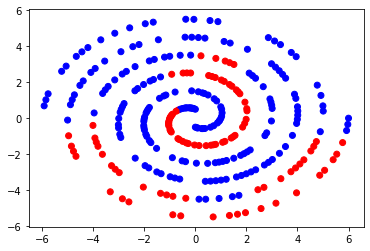

In [4]:
q2.train_evaluate(data_train_iter, data_test_iter, q2.u1, q2.v1, q2.b1, q2.u2, q2.v2, q2.b2)

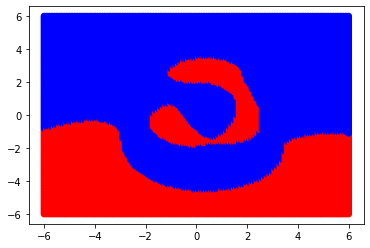

In [5]:
#q2.evaluate_spiral(data_test_iter, q2.u1_max, q2.v1_max, q2.b1_max, q2.u2_max, q2.v2_max, q2.b2_max)
#q2.decision_boundary(q2.u1_max, q2.v1_max, q2.b1_max, q2.u2_max, q2.v2_max, q2.b2_max)
q2.decision_boundary(q2.u1, q2.v1, q2.b1, q2.u2, q2.v2, q2.b2)

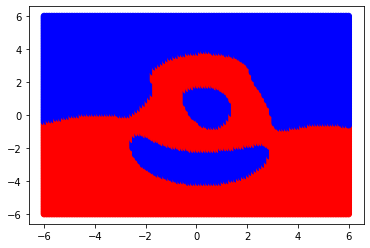

In [6]:
q2.decision_boundary(q2.u1_max, q2.v1_max, q2.b1_max, q2.u2_max, q2.v2_max, q2.b2_max) # highest accuracy

In [7]:
data_train = data_train.numpy()

In [8]:
data_train_in_0 = []
data_train_in_1 = []
data_train_out_0 = []
data_train_out_1 = []

for i in range(len(data_train)):
    if data_train[i][0] ** 2 + data_train[i][1] ** 2 <= 9.5:
        if data_train[i][2]:
            data_train_in_1.append(list(data_train[i]))
        else:
            data_train_in_0.append(list(data_train[i]))
    if data_train[i][0] ** 2 + data_train[i][1] ** 2 >= 8.5:
        if data_train[i][2]:
            data_train_out_1.append(list(data_train[i]))
        else:
            data_train_out_0.append(list(data_train[i]))
            
data_train_in_0 = torch.from_numpy(np.array(data_train_in_0))
data_train_in_1 = torch.from_numpy(np.array(data_train_in_1))
data_train_out_0 = torch.from_numpy(np.array(data_train_out_0))
data_train_out_1 = torch.from_numpy(np.array(data_train_out_1))

print(data_train_in_0.shape, data_train_in_1.shape, data_train_out_0.shape, data_train_out_1.shape)

torch.Size([80, 3]) torch.Size([64, 3]) torch.Size([85, 3]) torch.Size([80, 3])


In [9]:
q3_in_0 = SpiralNet(hidden = 512, batch = 30, r = 0.1, epoch = 8000)
q3_in_1 = SpiralNet(hidden = 512, batch = 30, r = 0.1, epoch = 8000)
q3_out_0 = SpiralNet(hidden = 512, batch = 30, r = 0.1, epoch = 8000)
q3_out_1 = SpiralNet(hidden = 512, batch = 30, r = 0.1, epoch = 8000)
q3_in_0_data = torch.cat((data_train_in_0, data_train_in_1, data_train_out_1), axis = 0)
q3_in_1_data = torch.cat((data_train_in_0, data_train_in_1, data_train_out_0), axis = 0)
q3_out_0_data = torch.cat((data_train_out_0, data_train_in_1, data_train_out_1), axis = 0)
q3_out_1_data = torch.cat((data_train_in_0, data_train_out_1, data_train_out_0), axis = 0)

In [10]:
q3_in_0_iter = q3_in_0.load_data(q3_in_0_data, True)
q3_in_1_iter = q3_in_1.load_data(q3_in_1_data, True)
q3_out_0_iter = q3_out_0.load_data(q3_out_0_data, True)
q3_out_1_iter = q3_out_1.load_data(q3_out_1_data, True)

In [ ]:
q3_in_0.train_evaluate(q3_in_0_iter, data_test_iter, q3_in_0.u1, q3_in_0.v1, q3_in_0.b1, q3_in_0.u2, q3_in_0.v2, q3_in_0.b2)

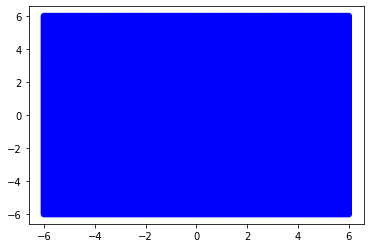

In [12]:
q3_in_0.decision_boundary(q3_in_0.u1, q3_in_0.v1, q3_in_0.b1, q3_in_0.u2, q3_in_0.v2, q3_in_0.b2)

loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489
loss: nan, accuracy: 0.7205240174672489


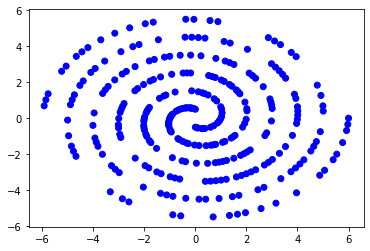

In [13]:
q3_in_1.train_evaluate(q3_in_1_iter, data_test_iter, q3_in_1.u1, q3_in_1.v1, q3_in_1.b1, q3_in_1.u2, q3_in_1.v2, q3_in_1.b2)

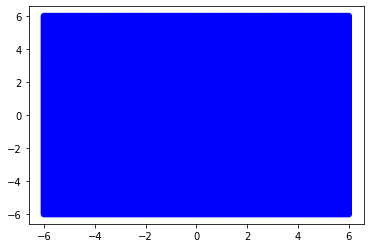

In [14]:
q3_in_1.decision_boundary(q3_in_1.u1, q3_in_1.v1, q3_in_1.b1, q3_in_1.u2, q3_in_1.v2, q3_in_1.b2)

max accuracy: 0.4978165938864629
loss: 3.2445266246795654, accuracy: 0.4978165938864629
max accuracy: 0.5327510917030568
loss: 1.7386746406555176, accuracy: 0.5327510917030568
max accuracy: 0.5764192139737991
loss: 1.0012255907058716, accuracy: 0.5764192139737991
loss: 1.1153762340545654, accuracy: 0.5545851528384279
max accuracy: 0.6069868995633187
loss: 0.5892412066459656, accuracy: 0.6069868995633187
loss: 0.7585726380348206, accuracy: 0.5676855895196506
max accuracy: 0.611353711790393
loss: 0.6072366237640381, accuracy: 0.611353711790393
max accuracy: 0.6157205240174672
loss: 0.7263003587722778, accuracy: 0.6157205240174672
max accuracy: 0.6244541484716157
loss: 0.5856679081916809, accuracy: 0.6244541484716157
loss: 0.6332281231880188, accuracy: 0.6157205240174672
max accuracy: 0.6593886462882096
loss: 0.620800793170929, accuracy: 0.6593886462882096
loss: 0.652094841003418, accuracy: 0.6506550218340611
loss: 0.6419848799705505, accuracy: 0.6200873362445415
loss: 0.5820738077163696,

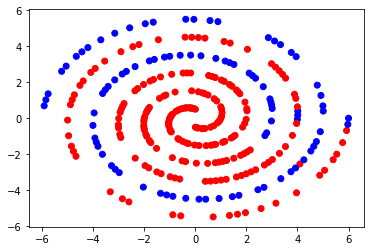

In [15]:
q3_out_0.train_evaluate(q3_out_0_iter, data_test_iter, q3_out_0.u1, q3_out_0.v1, q3_out_0.b1, q3_out_0.u2, q3_out_0.v2, q3_out_0.b2)

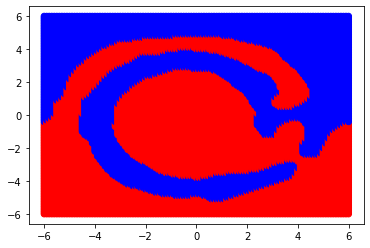

In [16]:
q3_out_0.decision_boundary(q3_out_0.u1, q3_out_0.v1, q3_out_0.b1, q3_out_0.u2, q3_out_0.v2, q3_out_0.b2)

max accuracy: 0.6408163265306123
loss: 2.1890904903411865, accuracy: 0.6408163265306123
loss: 1.6035627126693726, accuracy: 0.5510204081632653
loss: 1.2505862712860107, accuracy: 0.5836734693877551
max accuracy: 0.6857142857142857
loss: 0.6219936013221741, accuracy: 0.6857142857142857
loss: 0.5586686730384827, accuracy: 0.6857142857142857
loss: 0.6065605878829956, accuracy: 0.6653061224489796
max accuracy: 0.6938775510204082
loss: 0.6452327966690063, accuracy: 0.6938775510204082
loss: 0.5179097652435303, accuracy: 0.6571428571428571
loss: 0.6396886706352234, accuracy: 0.6653061224489796
loss: 0.5907300710678101, accuracy: 0.6775510204081633
loss: 0.6348327398300171, accuracy: 0.6571428571428571
loss: 0.5220153331756592, accuracy: 0.6653061224489796
loss: 0.5351672768592834, accuracy: 0.6816326530612244
loss: 0.5227401852607727, accuracy: 0.6816326530612244
loss: 0.5127193331718445, accuracy: 0.673469387755102
loss: 0.5170689225196838, accuracy: 0.6775510204081633
loss: 0.49735948443412

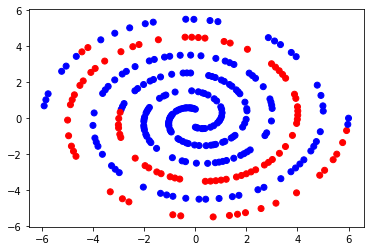

In [17]:
q3_out_1.train_evaluate(q3_out_1_iter, data_test_iter, q3_out_1.u1, q3_out_1.v1, q3_out_1.b1, q3_out_1.u2, q3_out_1.v2, q3_out_1.b2)

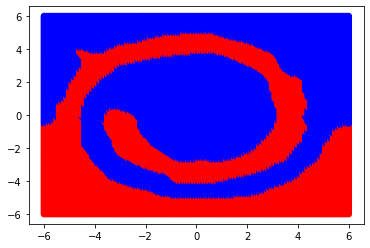

In [18]:
q3_out_1.decision_boundary(q3_out_1.u1, q3_out_1.v1, q3_out_1.b1, q3_out_1.u2, q3_out_1.v2, q3_out_1.b2)

accuracy: 0.96


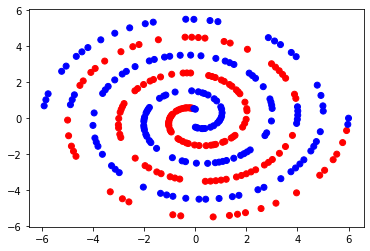

In [19]:
# min-max module
def plot_decision_boundary(x, y_class, color = ['b', 'r']):
    col = []
    for i in range(0, len(y_class)):
        col.append(color[y_class[i]])
    plt.scatter(x[:, 0], x[:, 1], c = col)

def max_min(in_0, in_1, out_0, out_1, test_iter): # 可以改成max或者不改
    accuracy_rate = [0., 0.]
    with torch.no_grad():
        for x, y in test_iter:
            y_hat_in_0 = in_0.mlqp(x, in_0.u1_max, in_0.v1_max, in_0.b1_max, in_0.u2_max, in_0.v2_max, in_0.b2_max)
            y_hat_in_0 = y_hat_in_0.argmax(axis=1)
            
            y_hat_in_1 = in_1.mlqp(x, in_1.u1_max, in_1.v1_max, in_1.b1_max, in_1.u2_max, in_1.v2_max, in_1.b2_max)
            y_hat_in_1 = y_hat_in_1.argmax(axis=1)
            
            y_hat_out_0 = out_0.mlqp(x, out_0.u1_max, out_0.v1_max, out_0.b1_max, out_0.u2_max, out_0.v2_max, out_0.b2_max)
            y_hat_out_0 = y_hat_out_0.argmax(axis=1)
            
            y_hat_out_1 = out_1.mlqp(x, out_1.u1_max, out_1.v1_max, out_1.b1_max, out_1.u2_max, out_1.v2_max, out_1.b2_max)
            y_hat_out_1 = y_hat_out_1.argmax(axis=1)
            
            y_hat = torch.max(torch.min(y_hat_in_0, y_hat_in_1), torch.min(y_hat_out_0, y_hat_out_1))
            
            plot_decision_boundary(x, y_hat)
            accuracy_rate[0] = accuracy_rate[0] + float((y_hat.type(y.dtype) == y).type(y.dtype).sum())
            accuracy_rate[1] = accuracy_rate[1] + y.numel()
        print('accuracy: {0}'.format(accuracy_rate[0] / accuracy_rate[1]))
        
        
max_min(q3_in_0, q3_in_1, q3_out_0, q3_out_1, data_test_iter)

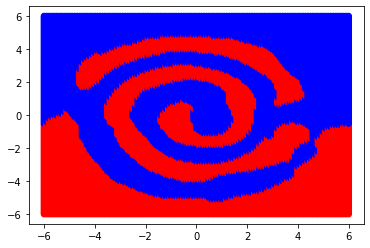

In [20]:
def max_min_boundary(in_0, in_1, out_0, out_1):
    x = torch.from_numpy(in_0.create_points(-6, 6, 121)).float()
    with torch.no_grad():
        y_hat_in_0 = in_0.mlqp(x, in_0.u1_max, in_0.v1_max, in_0.b1_max, in_0.u2_max, in_0.v2_max, in_0.b2_max)
        y_hat_in_0 = y_hat_in_0.argmax(axis=1)
            
        y_hat_in_1 = in_1.mlqp(x, in_1.u1_max, in_1.v1_max, in_1.b1_max, in_1.u2_max, in_1.v2_max, in_1.b2_max)
        y_hat_in_1 = y_hat_in_1.argmax(axis=1)
            
        y_hat_out_0 = out_0.mlqp(x, out_0.u1_max, out_0.v1_max, out_0.b1_max, out_0.u2_max, out_0.v2_max, out_0.b2_max)
        y_hat_out_0 = y_hat_out_0.argmax(axis=1)
            
        y_hat_out_1 = out_1.mlqp(x, out_1.u1_max, out_1.v1_max, out_1.b1_max, out_1.u2_max, out_1.v2_max, out_1.b2_max)
        y_hat_out_1 = y_hat_out_1.argmax(axis=1)
            
        y_hat = torch.max(torch.min(y_hat_in_0, y_hat_in_1), torch.min(y_hat_out_0, y_hat_out_1))
        plot_decision_boundary(x, y_hat)
        
max_min_boundary(q3_in_0, q3_in_1, q3_out_0, q3_out_1)